# Projet de Deep Learning : Prédiction de Séries Temporelles
---

## Projet 6 : Prédiction de Série Temporelle Financière

Dans ce projet, nous analysons une série temporelle financière donnée et construisons une base de données pour entraîner un modèle de deep learning capable de prédire le rendement futur R_{t+1}.

---

### Description du Problème

Nous considérons une série temporelle financière S_t de longueur totale N. Les données sont divisées en deux ensembles :
- **Entraînement** : N_t = 0.8 * N
- **Validation** : N_v = 0.2 * N

**Source des données** :
- À télécharger depuis [ce fichier CSV](https://turinici.com/wp-content/uploads/cours/common/close_cac40_historical.csv)
- Exemple : N = 255 * 10 (10 années de données journalières)

---

### Calculs à effectuer

Pour chaque point t de la série, nous calculons les éléments suivants :

1. **Rendements** :
   - \( R_t = log(S_t / S_{t-1}) \)

2. **Moyennes glissantes des rendements** (K) :
   - K = 5 (1 semaine, 1W)
   - K = 25 (1 mois, 1M)
   - K = 3 * 25 (3 mois, 3M)
   - K = 6 * 25 (6 mois, 6M)
   - K = 255 (1 an, 1Y)
   - K = 3 * 255 (3 ans, 3Y)

3. **Volatilité annualisée des K derniers rendements**.

4. **Autres indicateurs** :
   - Prix actuel S_t
   - Moyenne exponentielle (EMA) des K derniers prix, normalisée par S_t.

5. **Fenêtre glissante** :
   - Une fenêtre de longueur n contenant les prix S_{t-n}, ..., S_t.
   - Exemple : n = 3 * 25 (3 mois).

**Remarque** : Lorsque les données historiques ne permettent pas de calculer une moyenne sur la période complète K, utiliser la période la plus longue disponible (éviter les valeurs `NaN`).

---

### Objectif

La base de données finale contient les caractéristiques suivantes pour chaque point :
- N-1 points au total
- 15 caractéristiques calculées (rendements et volatilités)
- 1 prix actuel S_t
- 7 EMA des derniers prix (K)
- n prix de la fenêtre glissante

**Rendement cible** : R_{t+1}


In [ ]:
# 0) Importation des bibliothèques et configuration

# Commandes pip install (à exécuter une seule fois avant le premier lancement du script) :

!pip install numpy pandas matplotlib
!pip install pandas-ta
!pip install plotly
!pip install scikit-learn
!pip install tensorflow
!pip install keras 


# Bibliothèques standards
import numpy as np
import pandas as pd
import pandas_ta as ta  # Indicateurs financiers

# Visualisation
import matplotlib.pyplot as plt
import plotly.graph_objects as go  # Graphiques interactifs

# Prétraitement et modèles de machine learning (Sklearn)
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Deep Learning avec TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Système d'exploitation 
import os

# Fixation du seed pour garantir la reproductibilité
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Confirmation que tout est prêt
print("Libraries loaded and random seed fixed.")



## Étape 1 : Lecture et Prétraitement des Données

#### 1.1. Chargement des Données
Lecture des données depuis l'URL, sélection des colonnes nécessaires et renommage.

#### 1.2. Conversion des Données
Conversion de la colonne `Date` en format datetime et définition comme index.

#### 1.3. Nettoyage des Données
- Suppression des valeurs manquantes.
- Tri des données par date.

#### 1.4. Résumé des Données
- Aperçu des premières lignes après nettoyage.
- Dimensions des données après traitement.


In [ ]:
# URL des données
url = "https://turinici.com/wp-content/uploads/cours/common/close_cac40_historical.csv"

# Lecture du fichier CSV en ne chargeant que la colonne 'BNP.PA'
df_raw = pd.read_csv(url, sep=";", usecols=["Date", "BNP.PA"])

# Renommage des colonnes 
df_raw.rename(columns={"BNP.PA": "Price"}, inplace=True)

# Conversion de la colonne 'Date' en format datetime 
df_raw['Date'] = pd.to_datetime(df_raw['Date'])

# Définir la colonne 'Date' comme index
df_raw.set_index("Date", inplace=True)

print("\nAperçu des premières lignes :")
display(df_raw.head())
print("\nDimensions initiales :", df_raw.shape)

df_raw.dropna(subset=["Price"], inplace=True)

# Tri par index (date) pour s'assurer de l'ordre chronologique
df_raw.sort_index(inplace=True)

print("\nAperçu après nettoyage :")
display(df_raw.head())
print("\nDimensions après nettoyage :", df_raw.shape)




Aperçu des premières lignes :


,Price
Date,
2000-01-03,16.165972
2000-01-04,15.711578
2000-01-05,15.379528
2000-01-06,14.855226
2000-01-07,15.047465



Dimensions initiales : (8605, 1)

Aperçu après nettoyage :


,Price
Date,
1993-10-18,4.227787
1993-10-19,4.120383
1993-10-20,4.149676
1993-10-21,4.218023
1993-10-22,4.315662



Dimensions après nettoyage : (7339, 1)


## Étape 2 : Calcul des Caractéristiques et Préparation des Données

#### 2.1. Calcul du Rendement Logarithmique
- Calcul des rendements log : \( R_t = \log\left(\frac{X_t}{X_{t-1}}\right) \).
- Suppression des valeurs manquantes.

#### 2.2. Moyennes Mobiles et Volatilités Annualisées
- Calcul des moyennes mobiles des rendements sur des horizons \( K \) (1W, 1M, 3M, 6M, 1Y, 3Y).
- Calcul des volatilités annualisées pour les mêmes horizons.

#### 2.3. Moyennes Mobiles Exponentielles (EMA) / Prix
- Ratio entre EMA (Exponentially Moving Average) et le prix actuel pour chaque horizon \( K \).

#### 2.4. Fenêtre Glissante
- Création de variables décalées (lags) sur une fenêtre glissante de longueur \( n = 3 \times 25 \) jours.

#### 2.5. Cible : Rendement Futur
- Définition de la cible : \( R_{t+1} \), le rendement futur.

#### 2.6. Préparation des Features et de la Cible
- Séparation des données en :
  - **Features (X)** : Toutes les colonnes sauf `Price`, `Return`, et `FutureReturn`.
  - **Cible (y)** : Colonne `FutureReturn`.

#### 2.7. Normalisation des Features
- Standardisation des données (z-score) avec `StandardScaler` pour faciliter l'entraînement des modèles.


In [ ]:
# - Calcul des rendements log (R_t = log(X_t / X_{t-1}))
# - Moyennes mobiles sur K jours, volatilités annualisées
# - EMA (Exponentially Moving Average) / Price
# - Fenêtre glissante n = 3 * 25

df = df_raw.copy()

# 2.1 Calcul du rendement log
df["Return"] = np.log(df["Price"] / df["Price"].shift(1))
df = df.dropna()  # Retirer la première ligne NaN

# 2.2 Définition des horizons K
K_list = [5, 25, 75, 150, 252, 3*252]  # 1W, 1M, 3M, 6M, 1Y, 3Y
K_list = [K for K in K_list if K < len(df)]  # Filtrage pour les bases courtes

# Calcul des moyennes mobiles et volatilités annualisées
for K in K_list:
    df[f"meanRet_{K}"] = df["Return"].rolling(K).mean()
    df[f"meanRet_{K}"] = df[f"meanRet_{K}"].bfill()  

    df[f"vol_{K}"] = df["Return"].rolling(K).std() * np.sqrt(252)
    df[f"vol_{K}"] = df[f"vol_{K}"].bfill()  

# 2.4 EMA(K) / Price
for K in K_list:
    ema_series = df["Price"].ewm(span=K, adjust=False).mean()
    df[f"emaRatio_{K}"] = ema_series / df["Price"]
    df[f"emaRatio_{K}"] = df[f"emaRatio_{K}"].bfill()  

# 2.5 Fenêtre glissante
n = 25 * 3
for i in range(n):
    df[f"Price_lag_{i+1}"] = df["Price"].shift(i+1)

df = df.dropna()  

# 2.6 Cible = Rendement futur R_{t+1}
df["FutureReturn"] = df["Return"].shift(-1)
df = df.dropna()  

print(f"\nDimensions après feature engineering : {df.shape}")

# 2.7 Sélection des features (X) et de la cible (y)
exclude_cols = ["Price", "Return", "FutureReturn"]
feature_cols = [c for c in df.columns if c not in exclude_cols]
X = df[feature_cols].values
y = df["FutureReturn"].values

# 2.8 Normalisation (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature scaling terminé.")


Dimensions après feature engineering : (7262, 96)
Feature scaling terminé.


### Étape 3 : Visualisation des Données

#### 3.1. Prix et Moyennes Mobiles Exponentielles (EMA)
- Le premier sous-graphe affiche l'évolution du prix de l'action (`Price`) ainsi que les moyennes mobiles exponentielles (EMA) calculées sur 75, 150 et 252 jours.

#### 3.2. Volatilité Annualisée
- Le deuxième sous-graphe représente les volatilités annualisées pour les horizons de 75, 150 et 252 jours, permettant d'observer les variations du risque au fil du temps.

#### 3.3. Distribution des Rendements Logarithmiques
- Le troisième sous-graphe illustre la distribution des rendements logarithmiques (`Return`) sous forme d'histogramme. Une ligne verticale rouge indique la moyenne des rendements.

#### 3.4. Moyenne des Fenêtres Glissantes
- Le quatrième sous-graphe montre la moyenne des prix sur une fenêtre glissante de 5 lags, ce qui permet d'observer les tendances à court terme.

#### Organisation des Graphiques :
1. **Sous-graphe 1** : Évolution du prix et des EMA.
2. **Sous-graphe 2** : Comparaison des volatilités annualisées.
3. **Sous-graphe 3** : Distribution des rendements logarithmiques.
4. **Sous-graphe 4** : Moyenne des fenêtres glissantes.


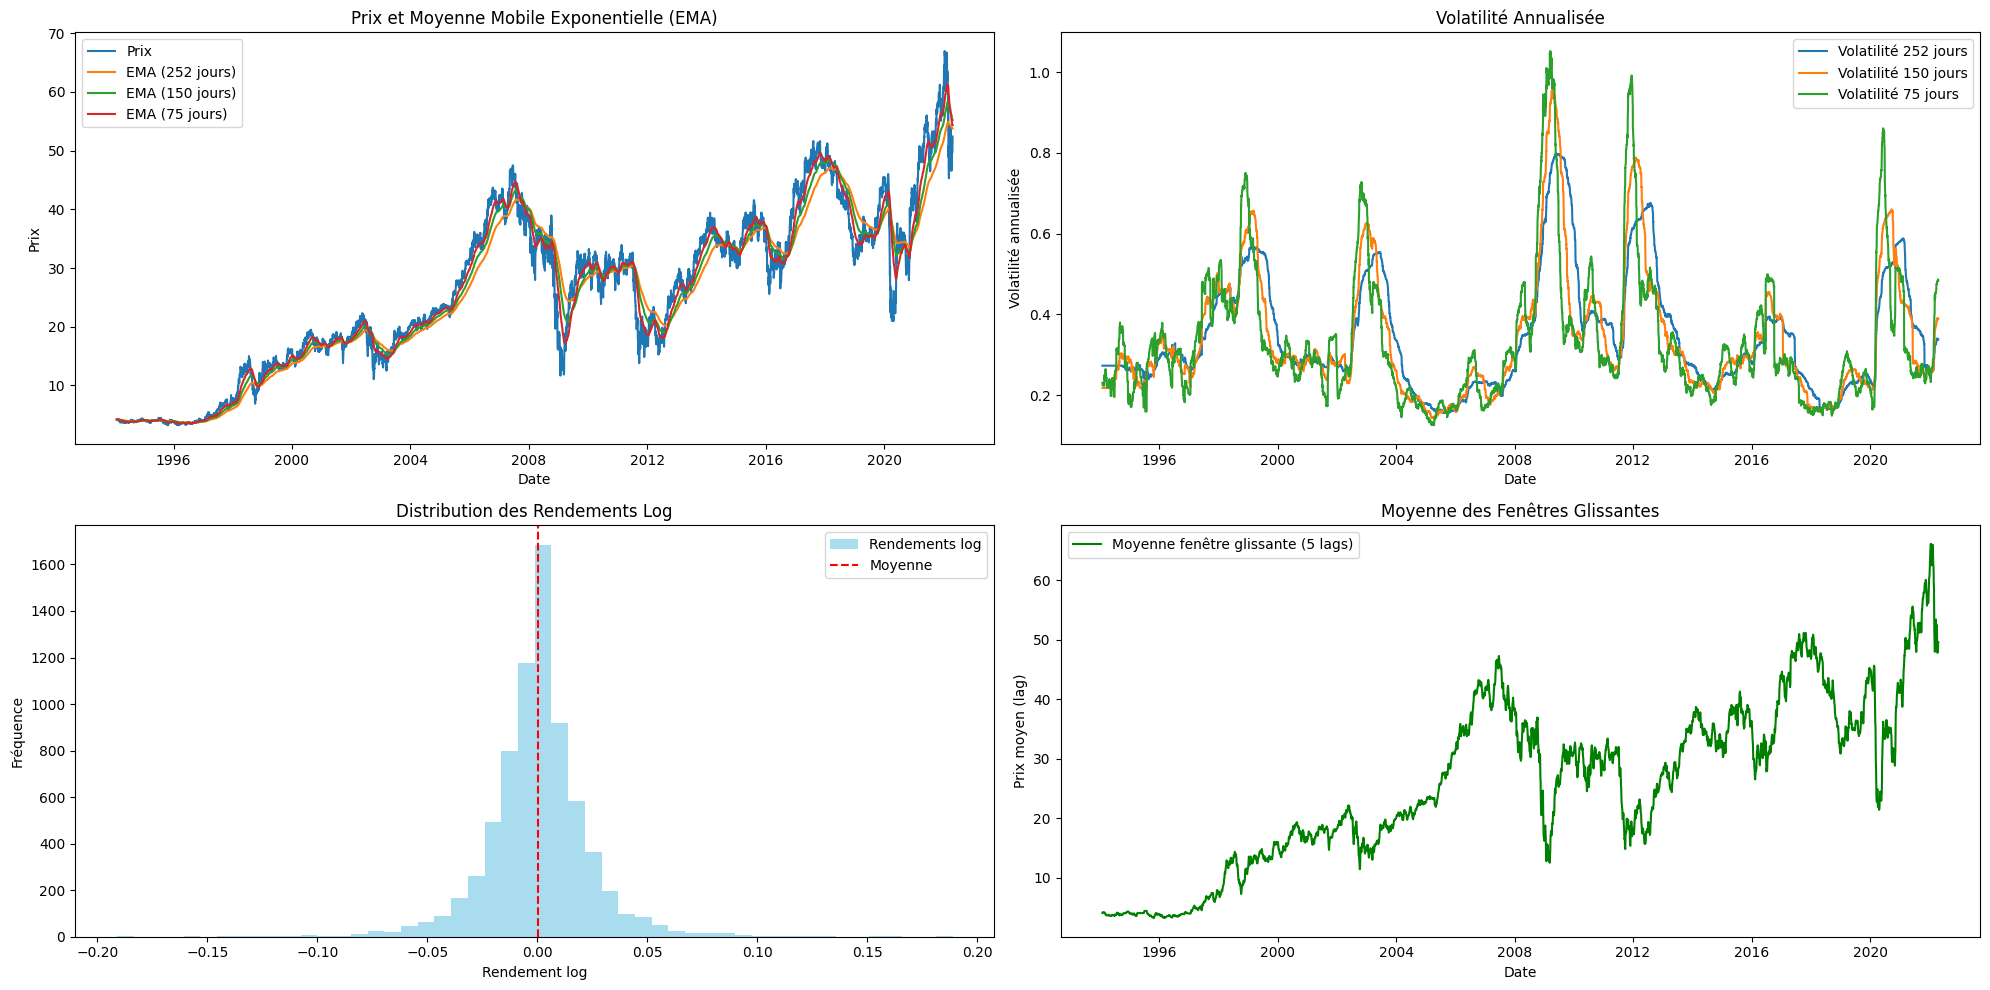

In [ ]:
plt.figure(figsize=(20, 10))

# Sous-graphe 1 : Prix et EMA
plt.subplot(2, 2, 1)
plt.plot(df.index, df["Price"], label="Prix")
plt.plot(df.index, df["Price"] * df["emaRatio_252"], label="EMA (252 jours)")
plt.plot(df.index, df["Price"] * df["emaRatio_150"], label="EMA (150 jours)")
plt.plot(df.index, df["Price"] * df["emaRatio_75"], label="EMA (75 jours)")
plt.title("Prix et Moyenne Mobile Exponentielle (EMA)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()

# Sous-graphe 2 : Volatilité annualisée
plt.subplot(2, 2, 2)
for K in [252, 150, 75]:
    plt.plot(df.index, df[f"vol_{K}"], label=f"Volatilité {K} jours")
plt.title("Volatilité Annualisée")
plt.xlabel("Date")
plt.ylabel("Volatilité annualisée")
plt.legend()

# Sous-graphe 3 : Distribution des rendements log
plt.subplot(2, 2, 3)
plt.hist(df["Return"], bins=50, color="skyblue", alpha=0.7, label="Rendements log")
plt.axvline(df["Return"].mean(), color="red", linestyle="--", label="Moyenne")
plt.title("Distribution des Rendements Log")
plt.xlabel("Rendement log")
plt.ylabel("Fréquence")
plt.legend()

# Sous-graphe 4 : Moyenne des fenêtres glissantes
window_avg = df[[f"Price_lag_{i+1}" for i in range(5)]].mean(axis=1)
plt.subplot(2, 2, 4)
plt.plot(df.index, window_avg, label="Moyenne fenêtre glissante (5 lags)", color="green")
plt.title("Moyenne des Fenêtres Glissantes")
plt.xlabel("Date")
plt.ylabel("Prix moyen (lag)")
plt.legend()

plt.tight_layout()
plt.show()


### Étape 4 : Séparation Temporelle des Données

#### 4.1. Division des Données
- Les données sont divisées en deux ensembles :
  - **Entraînement (Train)** : 80% des observations.
  - **Test** : 20% des observations restantes.

#### 4.2. Calcul des Dimensions
- Taille totale des données : \( N = \text{len(df)} \).
- Nombre d'observations pour l'entraînement : \( N_{\text{Train}} = 0.8 \cdot N \).
- Nombre d'observations pour le test : \( N_{\text{Test}} = N - N_{\text{Train}} \).

#### 4.3. Données Séparées
- **X_train** et **X_test** : Contiennent les features après normalisation.
- **y_train** et **y_test** : Contiennent la cible.

#### Dimensions des Données :
1. **Dataset complet** : \( N \)
2. **Entraînement** : \( N_{\text{Train}} \)
3. **Test** : \( N_{\text{Test}} \)


In [5]:
N = len(df)
Nt = int(0.8 * N)   # Nt := N_Train
Nv = N - Nt # Nv := N_Test

X_train, X_test = X_scaled[:Nt], X_scaled[Nt:]
y_train, y_test = y[:Nt], y[Nt:]

print("\nTaille dataset complet :", N)
print("Taille train :", Nt)
print("Taille test :", Nv)


Taille dataset complet : 7262
Taille train : 5809
Taille test : 1453


### Étape 5.1 : Modèle de Régression Linéaire

#### Description :
- Un modèle de **Régression Linéaire** est entraîné sur l'ensemble d'entraînement (\( X_{\text{Train}}, y_{\text{Train}} \)).
- Les prédictions sont effectuées sur l'ensemble de test (\( X_{\text{Test}} \)).

#### Métrique :
- Calcul de l'erreur quadratique moyenne (RMSE) sur l'ensemble de test pour évaluer les performances du modèle.
- La formule du RMSE est :

RMSE = sqrt[(1/n) * Σ (yᵢ - ŷᵢ)²]

où :
- \( yᵢ \) : Valeurs réelles (cible).
- \( ŷᵢ \) : Valeurs prédites par le modèle.
- \( n \) : Nombre total de points dans l'ensemble de test.

#### Résultat :
- **RMSE (Test)** : Affiché avec une précision de 6 décimales.


In [6]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred_lin = linreg.predict(X_test)

# Calcul du RMSE
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))

# Calcul du R^2
r2_lin = r2_score(y_test, y_pred_lin)

# Résultats
print(f"\nRégression Linéaire - RMSE test : {rmse_lin:.6f}")
print(f"Régression Linéaire - R^2 test   : {r2_lin:.6f}")



Régression Linéaire - RMSE test : 0.021756
Régression Linéaire - R^2 test   : -0.062385


In [ ]:
errors = np.array(y_test) - np.array(y_pred_lin)

fig = go.Figure()

# Ajout des vrais rendements
fig.add_trace(go.Scatter(
    x=list(range(len(y_test))),
    y=y_test,
    mode='lines+markers',
    name='Vrais rendements (Réels)',
    line=dict(color='blue', dash='solid'),
    marker=dict(symbol='circle'),
    opacity=0.7
))

# Ajout des prédictions
fig.add_trace(go.Scatter(
    x=list(range(len(y_pred_lin))),
    y=y_pred_lin,
    mode='lines+markers',
    name='Prédictions (Régression Linéaire)',
    line=dict(color='red', dash='dash'),
    marker=dict(symbol='x'),
    opacity=0.7
))

# Ajout des erreurs
fig.add_trace(go.Scatter(
    x=list(range(len(errors))),
    y=errors,
    mode='lines+markers',
    name='Erreur (Vrais - Prédictions)',
    line=dict(color='green', dash='dot'),
    marker=dict(symbol='triangle-up'),
    opacity=0.7
))

fig.update_layout(
    title="Vrais rendements VS Prédictions et Erreur (Régression Linéaire)",
    xaxis_title="Index Chronologique",
    yaxis_title="Rendement",
    legend=dict(font=dict(size=12)),
    grid=dict(rows=1, columns=1),
    template="plotly_white"
)

fig.show()


### Étape 5.2 : Modèle de Régression Linéaire avec Pénalisation Lasso

#### Description :
- Un modèle de **Régression Linéaire avec Pénalisation Lasso** est entraîné sur l'ensemble d'entraînement (\( X_{\text{Train}}, y_{\text{Train}} \)).
- Les prédictions sont effectuées sur l'ensemble de test (\( X_{\text{Test}} \)).
- La régularisation Lasso impose une pénalité proportionnelle à la somme des valeurs absolues des coefficients, favorisant ainsi la sélection de variables pertinentes.

#### Métrique :
- Calcul de l'erreur quadratique moyenne (RMSE) sur l'ensemble de test pour évaluer les performances du modèle.
- La formule du RMSE est :

\[
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}
\]

où :
- \( y_i \) : Valeurs réelles (cible).
- \( \hat{y}_i \) : Valeurs prédites par le modèle.
- \( n \) : Nombre total de points dans l'ensemble de test.

#### Résultat :
- **RMSE (Test)** : Affiché avec une précision de 6 décimales.
- **\( R^2 \) (Test)** : Mesure la proportion de variance expliquée par le modèle (affiché avec une précision de 6 décimales).


In [ ]:
lasso = Lasso(alpha=0.0001)
lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)

rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

# Résultats
print(f"\nRégression Lasso - RMSE test : {rmse_lasso:.6f}")
print(f"Régression Lasso - R^2 test   : {r2_lasso:.6f}")




Régression Lasso - RMSE test : 0.021231
Régression Lasso - R^2 test   : -0.011724


In [9]:
errors_lasso = np.array(y_test) - np.array(y_pred_lasso)

fig_lasso = go.Figure()

# Ajout des vrais rendements
fig_lasso.add_trace(go.Scatter(
    x=list(range(len(y_test))),
    y=y_test,
    mode='lines+markers',
    name='Vrais rendements (Réels)',
    line=dict(color='blue', dash='solid'),
    marker=dict(symbol='circle'),
    opacity=0.7
))

# Ajout des prédictions Lasso
fig_lasso.add_trace(go.Scatter(
    x=list(range(len(y_pred_lasso))),
    y=y_pred_lasso,
    mode='lines+markers',
    name='Prédictions (Régression Lasso)',
    line=dict(color='red', dash='dash'),
    marker=dict(symbol='x'),
    opacity=0.7
))

# Ajout des erreurs pour Lasso
fig_lasso.add_trace(go.Scatter(
    x=list(range(len(errors_lasso))),
    y=errors_lasso,
    mode='lines+markers',
    name='Erreur (Vrais - Prédictions Lasso)',
    line=dict(color='green', dash='dot'),
    marker=dict(symbol='triangle-up'),
    opacity=0.7
))

fig_lasso.update_layout(
    title="Vrais rendements VS Prédictions et Erreur (Régression Lasso)",
    xaxis_title="Index Chronologique",
    yaxis_title="Rendement",
    legend=dict(font=dict(size=12)),
    grid=dict(rows=1, columns=1),
    template="plotly_white"
)

fig_lasso.show()


### Étape 5.3 : Modèle Random Forest

#### Description :
- Un modèle de **Random Forest Regressor** est entraîné sur l'ensemble d'entraînement (\( X_{\text{Train}}, y_{\text{Train}} \)).
- Les prédictions sont effectuées sur l'ensemble de test (\( X_{\text{Test}} \)).
- Le modèle Random Forest combine plusieurs arbres de décision pour améliorer la précision et réduire le risque de sur-apprentissage.

#### Métrique :
- Calcul de l'erreur quadratique moyenne (RMSE) sur l'ensemble de test pour évaluer les performances du modèle.
- La formule du RMSE est :

\[
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2}
\]

où :
- \( y_i \) : Valeurs réelles (cible).
- \( \hat{y}_i \) : Valeurs prédites par le modèle.
- \( n \) : Nombre total de points dans l'ensemble de test.

#### Résultat :
- **RMSE (Test)** : Affiché avec une précision de 6 décimales.
- **\( R^2 \) (Test)** : Mesure la proportion de variance expliquée par le modèle (affiché avec une précision de 6 décimales).


In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"\nRégression Random Forest - RMSE test : {rmse_rf:.6f}")
print(f"Régression Random Forest - R^2 test   : {r2_rf:.6f}")


KeyboardInterrupt: 

In [ ]:
errors_rf = np.array(y_test) - np.array(y_pred_rf)

fig_rf = go.Figure()

# Ajout des vrais rendements
fig_rf.add_trace(go.Scatter(
    x=list(range(len(y_test))),
    y=y_test,
    mode='lines+markers',
    name='Vrais rendements (Réels)',
    line=dict(color='blue', dash='solid'),
    marker=dict(symbol='circle'),
    opacity=0.7
))

# Ajout des prédictions Random Forest
fig_rf.add_trace(go.Scatter(
    x=list(range(len(y_pred_rf))),
    y=y_pred_rf,
    mode='lines+markers',
    name='Prédictions (Random Forest)',
    line=dict(color='red', dash='dash'),
    marker=dict(symbol='x'),
    opacity=0.7
))

# Ajout des erreurs pour Random Forest
fig_rf.add_trace(go.Scatter(
    x=list(range(len(errors_rf))),
    y=errors_rf,
    mode='lines+markers',
    name='Erreur (Vrais - Prédictions RF)',
    line=dict(color='green', dash='dot'),
    marker=dict(symbol='triangle-up'),
    opacity=0.7
))

fig_rf.update_layout(
    title="Vrais rendements VS Prédictions et Erreur (Random Forest)",
    xaxis_title="Index Chronologique",
    yaxis_title="Rendement",
    legend=dict(font=dict(size=12)),
    grid=dict(rows=1, columns=1),
    template="plotly_white"
)

fig_rf.show()


### Étape 6 : Analyse des Features Importantes

#### Description :
Cette étape consiste à identifier les features les plus importantes pour chaque modèle (Régression Linéaire, Régression Lasso, Random Forest) afin de mieux comprendre les contributions des différentes variables.

#### Étapes Réalisées :
1. **Régression Linéaire** :
   - Les coefficients du modèle sont extraits et triés par leur valeur absolue.
   - Seules les 10 features les plus importantes sont affichées pour une meilleure lisibilité.

2. **Régression Lasso** :
   - Les coefficients du modèle Lasso sont extraits et triés par leur valeur absolue.
   - Limitation aux 10 principales features.

3. **Random Forest** :
   - Les importances des features sont calculées à partir de l'arbre d'ensemble.
   - Les 10 features les plus importantes sont affichées.

#### Graphiques Affichés :
- **Graphique 1** : Top 10 des features les plus importantes pour la Régression Linéaire.
- **Graphique 2** : Top 10 des features les plus importantes pour la Régression Lasso.
- **Graphique 3** : Top 10 des features les plus importantes pour le modèle Random Forest.

#### Résultat :
Les graphiques permettent de comparer les features les plus significatives pour chaque méthode et d'observer comment chaque modèle les évalue en fonction de sa logique d'entraînement.


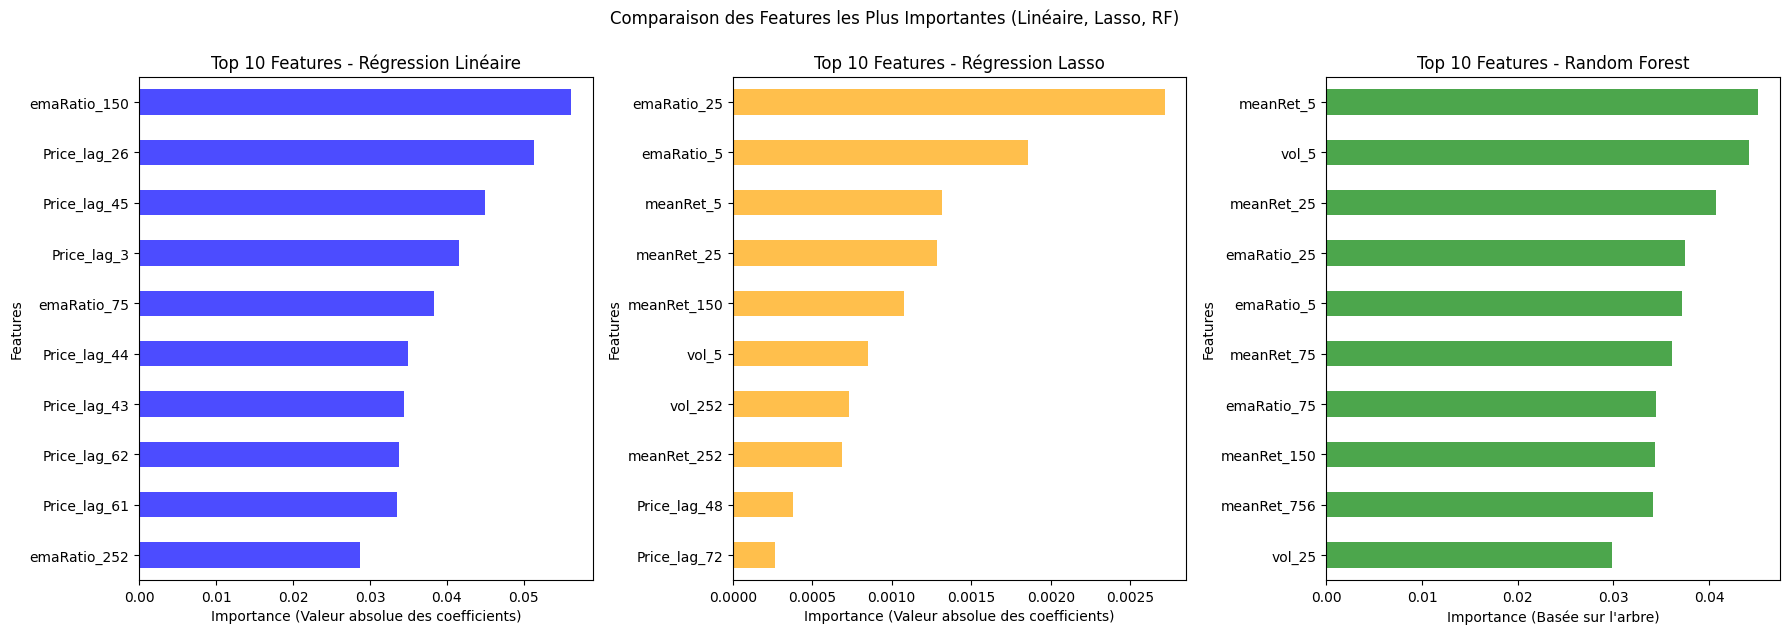

In [12]:
# Calcul des coefficients pour les modèles linéaire et Lasso
coefficients_linreg = pd.Series(linreg.coef_, index=df[feature_cols].columns)
coefficients_linreg = coefficients_linreg.abs().sort_values(ascending=False)

coefficients_lasso = pd.Series(lasso.coef_, index=df[feature_cols].columns)
coefficients_lasso = coefficients_lasso.abs().sort_values(ascending=False)

# Importance des features pour Random Forest
importances_rf = pd.Series(rf.feature_importances_, index=df[feature_cols].columns)
importances_rf = importances_rf.sort_values(ascending=False)

# Limiter aux 10 features les plus importantes pour une meilleure lisibilité
top_n = 10
top_features_linreg = coefficients_linreg.head(top_n)
top_features_lasso = coefficients_lasso.head(top_n)
top_features_rf = importances_rf.head(top_n)

# Création de la figure pour la comparaison
plt.figure(figsize=(18, 6))

# Graphique pour la régression linéaire
plt.subplot(1, 3, 1)
top_features_linreg.plot(kind='barh', color='blue', alpha=0.7)
plt.title("Top 10 Features - Régression Linéaire")
plt.xlabel("Importance (Valeur absolue des coefficients)")
plt.ylabel("Features")
plt.gca().invert_yaxis()  

# Graphique pour la régression Lasso
plt.subplot(1, 3, 2)
top_features_lasso.plot(kind='barh', color='orange', alpha=0.7)
plt.title("Top 10 Features - Régression Lasso")
plt.xlabel("Importance (Valeur absolue des coefficients)")
plt.ylabel("Features")
plt.gca().invert_yaxis()

# Graphique pour Random Forest
plt.subplot(1, 3, 3)
top_features_rf.plot(kind='barh', color='green', alpha=0.7)
plt.title("Top 10 Features - Random Forest")
plt.xlabel("Importance (Basée sur l'arbre)")
plt.ylabel("Features")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.suptitle("Comparaison des Features les Plus Importantes (Linéaire, Lasso, RF)", y=1.05)
plt.show()


### Commentaire : Comparaison des Features les Plus Importantes

#### Analyse des Graphiques :
1. **Régression Linéaire** :
   - Les variables les plus importantes sont principalement liées aux moyennes mobiles exponentielles (`emaRatio`) et aux décalages temporels des prix (`Price_lag`).
   - `emaRatio_150` est la feature la plus influente, ce qui suggère que la tendance à moyen terme joue un rôle clé dans les prédictions.

2. **Régression Lasso** :
   - Lasso sélectionne des features avec des coefficients plus petits, indiquant qu'il favorise une régularisation plus forte.
   - `emaRatio_25` et `emaRatio_5` sont les plus importantes, montrant l'importance des tendances à court terme.
   - Les rendements moyens (`meanRet_5`, `meanRet_25`) et la volatilité (`vol_5`) apparaissent également comme significatifs.

3. **Random Forest** :
   - Les features les plus importantes sont dominées par les rendements moyens (`meanRet`) et la volatilité (`vol`).
   - `meanRet_5` et `vol_5` sont les deux features les plus influentes, suggérant que Random Forest privilégie des indicateurs liés à la performance récente.

#### Conclusion :
- Chaque modèle met en avant des variables différentes, ce qui reflète leurs mécanismes d'entraînement spécifiques.
- Les tendances (EMA), rendements moyens, et volatilités jouent des rôles majeurs dans les prédictions.
- Random Forest, en particulier, semble accorder plus de poids aux indicateurs récents, ce qui pourrait mieux capturer les fluctuations à court terme.


In [ ]:
# Comparaison des métriques pour chaque modèle
results = {
    "Modèle": ["Régression Linéaire", "Régression Lasso", "Random Forest"],
    "RMSE (Test)": [rmse_lin, rmse_lasso, rmse_rf],
    "R² (Test)": [r2_lin, r2_lasso, r2_rf]
}

# Création d'un DataFrame pour afficher les résultats
results_df = pd.DataFrame(results)

# Affichage de la table directement dans le notebook
from IPython.display import display
display(results_df)



NameError: name 'mse_lin' is not defined

### Commentaire sur les Résultats

#### 1. Analyse des RMSE :
- **Régression Lasso** a le plus faible RMSE (0.021231), ce qui indique qu'elle minimise mieux l'écart entre les prédictions et les valeurs réelles par rapport aux autres modèles.
- **Régression Linéaire** suit de près avec un RMSE de 0.021756, mais elle reste légèrement moins performante que Lasso.
- **Random Forest** affiche le plus grand RMSE (0.023220), suggérant que ce modèle n'est pas aussi adapté pour cette tâche ou que ses hyperparamètres pourraient être optimisés.

#### 2. Analyse des \( R^2 \) (Coefficient de Détermination) :
- Tous les modèles ont des \( R^2 \) **négatifs**, ce qui signifie que les prédictions sont moins performantes que simplement utiliser la moyenne des valeurs cibles (\( y \)).
  - **Régression Lasso** : \( R^2 = -0.011724 \), le plus proche de 0, ce qui indique qu'elle explique mieux la variance des données que les autres modèles.
  - **Régression Linéaire** : \( R^2 = -0.062385 \), moins performant que Lasso, mais meilleur que Random Forest.
  - **Random Forest** : \( R^2 = -0.210179 \), le pire score parmi les trois, indiquant une mauvaise adéquation avec les données.

#### 3. Interprétation Globale :
- Les \( R^2 \) négatifs montrent que les modèles testés ne capturent pas bien la structure des données.
- **Régression Lasso** semble légèrement mieux adaptée, mais tous les modèles pourraient bénéficier de :
  - **Amélioration des Features** : Ajouter des transformations pertinentes ou réduire le bruit.
  - **Optimisation des Hyperparamètres** : Ajuster les paramètres (comme `alpha` pour Lasso ou `n_estimators` pour Random Forest).
  - **Modèles plus Sophistiqués** : Essayer des approches non linéaires comme des réseaux de neurones ou des modèles basés sur des gradients (XGBoost, LightGBM).


## Étape 7 : Pré-traitement des Données pour les Séries Temporelles

#### Objectif :
- Préparer les données sous un format séquentiel pour permettre l'entraînement d'un modèle basé sur les séries temporelles.
- Prédire l'intervalle auquel appartient le rendement futur (`FutureReturn`), en utilisant une approche inspirée du papier LLM de Brugière et Turinici.

#### Étapes Réalisées :
1. **Discrétisation des Rendements** :
   - Le rendement futur est discrétisé en \( n \) intervalles (quantiles).
   - Chaque intervalle correspond à un "bucket" pour la classification.

2. **Séparation des Données** :
   - Division des données en ensemble d'entraînement (80%) et de test (20%).
   - Normalisation des données avec `StandardScaler`.

3. **Création des Séquences** :
   - Découpage des données en séquences de longueur fixe (\( seq\_length = 35 \)).
   - Chaque séquence contient \( seq\_length \) observations consécutives pour former les entrées du modèle.

4. **Conversion en Catégories** :
   - Les cibles (`FutureReturn_bucket`) sont converties en one-hot encoding pour une classification multi-classes.

#### Résultat :
- Les données sont prêtes sous un format séquentiel pour l'entraînement d'un modèle de séries temporelles.
- Exemple de formes des données générées :
  - **X_train_seq** : Séquences d'entraînement (\( \text{shape} = \text{(n\_samples, seq\_length, n\_features)} \)).
  - **y_train_seq** : Cibles d'entraînement (\( \text{shape} = \text{(n\_samples, n\_classes)} \)).


In [ ]:
df_seq = df.copy()

n_buckets = 7
quantiles = np.linspace(0, 1, n_buckets+1)  
cuts = df_seq['FutureReturn'].quantile(quantiles).values

print("Cut edges (quantiles):", cuts)

df_seq['FutureReturn_bucket'] = pd.cut(
    df_seq['FutureReturn'],
    bins=cuts,            
    labels=False,         
    include_lowest=True   
)

exclude_cols_seq = ["Price", "Return", "FutureReturn", "FutureReturn_bucket"]
feature_cols_seq = [c for c in df_seq.columns if c not in exclude_cols_seq]
X_seq = df_seq[feature_cols_seq].values
y_seq = df_seq["FutureReturn_bucket"].values.astype(int)  

N_seq = len(df_seq)
Nt_seq = int(0.8 * N_seq)
Nv_seq = N_seq - Nt_seq

X_train_seq, X_test_seq = X_seq[:Nt_seq], X_seq[Nt_seq:]
y_train_seq, y_test_seq = y_seq[:Nt_seq], y_seq[Nt_seq:]
scaler_seq = StandardScaler()
X_train_scaled_seq = scaler_seq.fit_transform(X_train_seq)
X_test_scaled_seq  = scaler_seq.transform(X_test_seq)

seq_length = 35

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)


X_train_seq, y_train_seq = create_sequences(X_train_scaled_seq, y_train_seq, seq_length)
X_test_seq,  y_test_seq  = create_sequences(X_test_scaled_seq,  y_test_seq,  seq_length)

print(f"Forme X_train_seq : {X_train_seq.shape}")
print(f"Forme y_train_seq : {y_train_seq.shape}")

y_train_cat = to_categorical(y_train_seq, num_classes=n_buckets)
y_test_cat  = to_categorical(y_test_seq,  num_classes=n_buckets)

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)



Cut edges (quantiles): [-0.19116565 -0.01847911 -0.00820182 -0.00163373  0.00193319  0.00858055
  0.01926849  0.18874477]
Forme X_train_seq : (5774, 35, 93)
Forme y_train_seq : (5774,)


### Étape 7.1 : Construction du Modèle LSTM

#### Description :
- Un modèle séquentiel LSTM est créé pour traiter les données sous forme de séquences temporelles.
- L'objectif est de prédire l'intervalle auquel appartient le rendement futur (`FutureReturn_bucket`) en utilisant une classification multi-classes.

#### Architecture du Modèle :
1. **Entrée** : Forme de l'entrée basée sur la séquence temporelle (\( seq\_length, \text{n\_features} \)).
2. **Couche LSTM** :
   - Une première couche LSTM avec 64 unités, qui retourne des séquences.
   - Une deuxième couche LSTM avec 64 unités, qui retourne un vecteur final.
3. **Couches Intermédiaires** :
   - Couches de Dropout (0.1) pour réduire le sur-apprentissage.
   - Une couche dense avec 32 unités et une activation `relu`.
4. **Sortie** :
   - Une couche dense avec \( n\_buckets \) unités et une activation `softmax` pour une classification multi-classes.

#### Compilation :
- Optimiseur : Adam avec un taux d'apprentissage de 0.001.
- Fonction de perte : Categorical Crossentropy.
- Métrique : Précision (`accuracy`).



In [28]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_length, X_train_seq.shape[2])),
    tf.keras.layers.LSTM(128, return_sequences=True, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(64, return_sequences=False, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(n_buckets, activation='softmax')  
])

model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model_lstm.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 35, 64)         │        40,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 35, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,783 (296.03 KB)

 Trainable params: 75,783 (296.03 KB)

 Non-trainable params: 0 (0.00 B)

### Train du modèle LSTM

In [ ]:
history_lstm = model_lstm.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=10,
    batch_size=32,
    verbose=1
)

test_loss, test_acc = model_lstm.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"\nTest loss (cross-entropy) : {test_loss:.4f}")
print(f"Test accuracy             : {test_acc:.2%}")
y_proba = model_lstm.predict(X_test_seq)
predicted_buckets = np.argmax(y_proba, axis=1)


Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.2072 - loss: 2.1198 - val_accuracy: 0.1848 - val_loss: 1.9367
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.2315 - loss: 1.8837 - val_accuracy: 0.1918 - val_loss: 1.9129
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.2549 - loss: 1.8355 - val_accuracy: 0.1834 - val_loss: 1.9031
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.2421 - loss: 1.8155 - val_accuracy: 0.1855 - val_loss: 1.8941
Epoch 5/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.2601 - loss: 1.8087 - val_accuracy: 0.1918 - val_loss: 1.9000
Epoch 6/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.2567 - loss: 1.8041 - val_accuracy: 0.1975 - val_loss: 1.8879
Epoch 7/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.2683 - loss: 1.7951 - val_accuracy: 0.2010 - val_loss: 1.8916
Epoch 8/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.2620 - loss: 1.7931 - val_acc

### Evolution de la Loss pour le train et le test

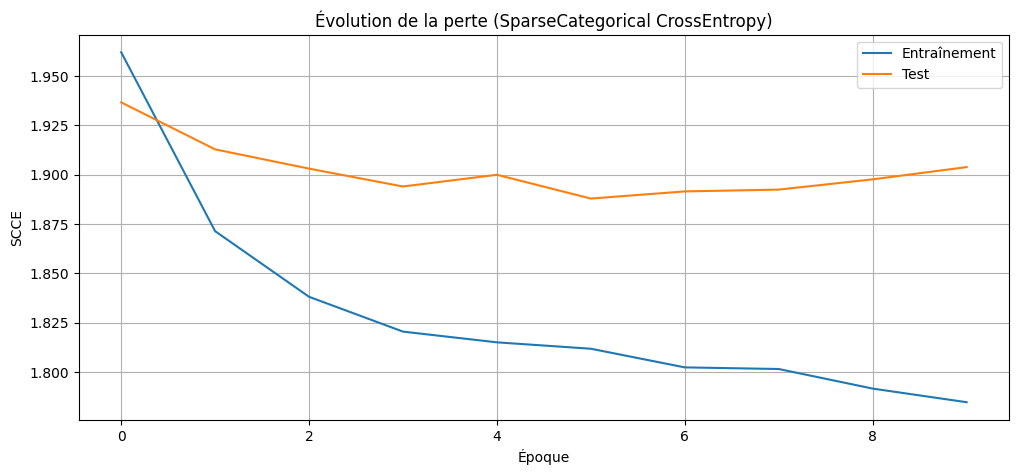

In [30]:
# Courbes d'entraînement et de validation
plt.figure(figsize=(12, 5))
plt.plot(history_lstm.history['loss'], label='Entraînement')
plt.plot(history_lstm.history['val_loss'], label='Test')
plt.title('Évolution de la perte (SparseCategorical CrossEntropy)')
plt.xlabel('Époque')
plt.ylabel('SCCE')
plt.legend()
plt.grid(True)
plt.show()

#### Comparaison des Répartitions Réelles et Prédites

#### Objectif :
- Comparer les fréquences réelles des classes (\( y_{\text{test}} \)) avec les fréquences prédites :
  1. En utilisant la classe prédite la plus probable (argmax).
  2. En utilisant les probabilités moyennes prédites pour chaque classe.

#### Résultat :
- Deux graphiques :
  1. **Répartition réelle vs prédite (argmax)** : Compare les classes les plus probables.
  2. **Répartition réelle vs probabilité moyenne** : Compare les fréquences réelles avec les moyennes des prédictions.


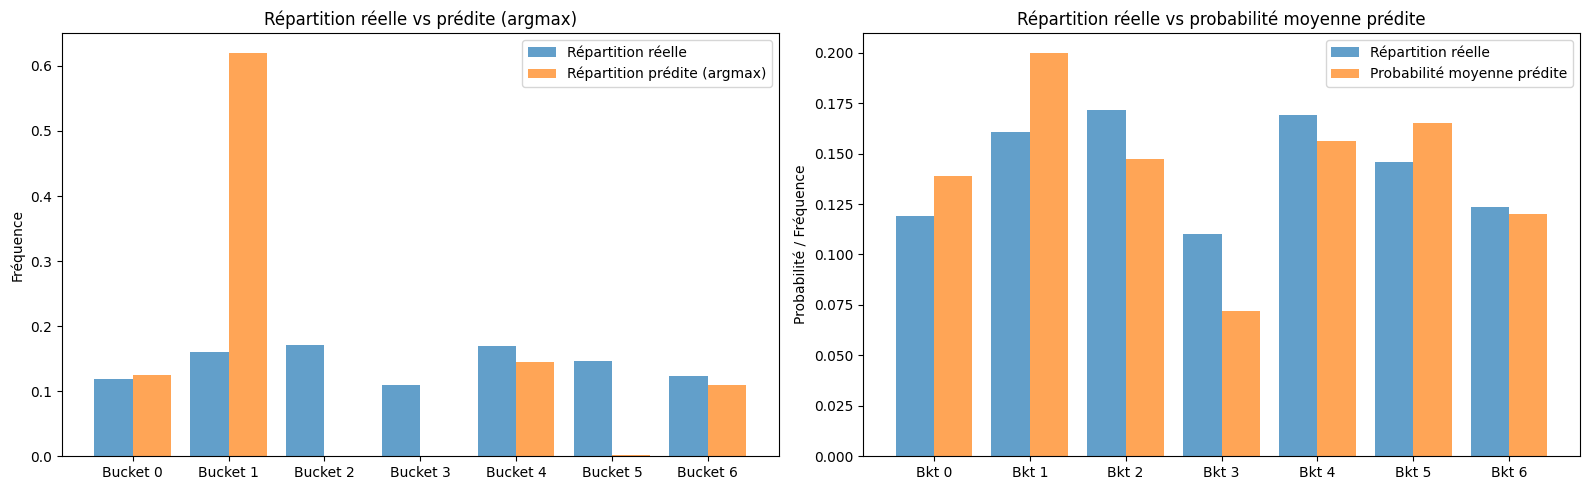

In [18]:
# Calcul des fréquences réelles (true_freq)
true_counts = np.bincount(y_test_seq, minlength=n_buckets)  # Comptage des classes réelles
true_freq = true_counts / true_counts.sum()  # Normalisation en fréquences

# Calcul des fréquences prédites (argmax) (pred_freq)
pred_counts = np.bincount(predicted_buckets, minlength=n_buckets)  # Comptage des classes prédites
pred_freq = pred_counts / pred_counts.sum()  # Normalisation en fréquences


n_buckets = len(true_freq) 
indices = np.arange(n_buckets)
bar_width = 0.4


# Visualisation des distributions
plt.figure(figsize=(16, 5))

# Graphique 1 : Répartition réelle vs prédite (argmax)
plt.subplot(1, 2, 1)
plt.bar(indices - bar_width / 2, true_freq, width=bar_width, alpha=0.7, label="Répartition réelle")
plt.bar(indices + bar_width / 2, pred_freq, width=bar_width, alpha=0.7, label="Répartition prédite (argmax)")
plt.xticks(indices, [f"Bucket {i}" for i in indices])
plt.ylabel("Fréquence")
plt.title("Répartition réelle vs prédite (argmax)")
plt.legend()

# Distribution réelle vs Probabilité moyenne prédite
mean_proba = y_proba.mean(axis=0)  # Moyenne des probabilités prédites pour chaque bucket

# Graphique 2 : Répartition réelle vs probabilité moyenne
plt.subplot(1, 2, 2)
plt.bar(indices - bar_width / 2, true_freq, width=bar_width, alpha=0.7, label="Répartition réelle")
plt.bar(indices + bar_width / 2, mean_proba, width=bar_width, alpha=0.7, label="Probabilité moyenne prédite")
plt.xticks(indices, [f"Bkt {i}" for i in indices])
plt.ylabel("Probabilité / Fréquence")
plt.title("Répartition réelle vs probabilité moyenne prédite")
plt.legend()

# Mise en page
plt.tight_layout()
plt.show()


### Commentaire :

1. **Graphique 1 : Répartition réelle vs prédite (argmax)** :
   - La classe prédite (Bucket 1) est sur-représentée par rapport aux autres, ce qui peut indiquer un biais dans le modèle.
   - Les autres classes sont sous-représentées, montrant que le modèle a du mal à différencier certaines catégories.

2. **Graphique 2 : Répartition réelle vs probabilité moyenne prédite** :
   - Les probabilités moyennes prédites sont plus équilibrées que les classes argmax, mais des écarts significatifs subsistent avec les fréquences réelles, en particulier pour les Buckets 3 et 6.
   - Cela suggère que le modèle capture globalement les tendances, mais reste perfectible pour représenter certaines classes de manière plus précise.

#### Conclusion :
- Un ajustement des données ou une révision des hyperparamètres pourrait être nécessaire pour améliorer la différenciation entre les classes.


### Étape 7.2 : Construction du Modèle Temporal Fusion Transformer (TFT)

#### Description :
- Un modèle basé sur l'architecture **Transformer** est construit pour traiter les données sous forme de séquences temporelles.
- L'objectif est de prédire l'intervalle auquel appartient le rendement futur (`FutureReturn_bucket`) en utilisant une classification multi-classes.

#### Architecture du Modèle :
1. **Entrée** : Données séquentielles de forme (\( seq\_length, \text{num\_features} \)).
2. **Positional Encoding** :
   - Encode les informations de position dans les séquences pour capturer l'ordre temporel des données.
3. **Transformer Encoder** :
   - Composé de plusieurs couches de :
     - **Multi-head Attention** : Capture les relations entre les pas de temps.
     - **Feed-Forward Network (FFN)** : Applique des transformations non linéaires sur les données.
     - **Layer Normalization** et **Dropout** : Pour stabiliser l'entraînement et réduire le sur-apprentissage.
   - Nombre de couches contrôlé par `num_layers`.
4. **Gated Linear Unit (GLU)** :
   - Une unité linéaire "gated" qui améliore la capacité du modèle à capturer des relations complexes.
5. **Sortie** :
   - Une couche dense avec \( n\_buckets \) unités et une activation `softmax` pour une classification multi-classes.

#### Compilation :
- **Optimiseur** : Adam avec un taux d'apprentissage de 0.001.
- **Fonction de perte** : Sparse Categorical Crossentropy.
- **Métrique** : Précision (`accuracy`).

#### Points Clés :
- L'intégration des mécanismes d'attention et de positional encoding permet au modèle de capturer les relations temporelles et contextuelles complexes dans les séquences.
- Le modèle est conçu pour être extensible à plusieurs tâches temporelles et séries multivariées.

#### Prochaine Étape :
- Entraîner le modèle sur les données séquentielles préparées.
- Comparer ses performances avec le modèle LSTM et les approches plus classiques.


In [20]:
class TransformerEncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, x):
        # Multi-head attention
        attn_output = self.mha(x, x, x)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)

        # FFN
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

# PositionalEncoding
class PositionalEncoding(layers.Layer):
    def __init__(self, max_position, d_model):
        super().__init__()
        self.d_model = d_model
        pe = np.zeros((max_position, d_model))
        position = np.arange(0, max_position)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        self.pe = tf.constant(pe, dtype=tf.float32)

    def call(self, x):
        seq_length = tf.shape(x)[1]
        return x + self.pe[:seq_length, :]

# GatedLinearUnit
class GatedLinearUnit(layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.dense = layers.Dense(units)
        self.sigmoid = layers.Dense(units, activation='sigmoid')

    def call(self, inputs):
        return self.dense(inputs) * self.sigmoid(inputs)

# TemporalFusionTransformer pour la classification
class TemporalFusionTransformer:
    def __init__(self, seq_length, num_features,
                 d_model=64, num_heads=4, dff=128, num_layers=2,
                 dropout_rate=0.1, n_buckets=7):
        self.seq_length = seq_length
        self.num_features = num_features
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.n_buckets = n_buckets

    def build_model(self):
        inputs = layers.Input(shape=(self.seq_length, self.num_features))

        x = layers.Dense(self.d_model)(inputs)

        x = PositionalEncoding(self.seq_length, self.d_model)(x)

        for _ in range(self.num_layers):
            x = TransformerEncoderLayer(self.d_model, self.num_heads, self.dff, self.dropout_rate)(x)

        x = layers.GlobalAveragePooling1D()(x)

        x = GatedLinearUnit(self.d_model)(x)

        outputs = layers.Dense(self.n_buckets, activation='softmax')(x)

        model = models.Model(inputs=inputs, outputs=outputs)

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy']
        )
        return model


In [21]:

num_features = X_train_seq.shape[2]


tft = TemporalFusionTransformer(
    seq_length=seq_length,
    num_features=num_features,
    n_buckets=n_buckets   
)
model_TFT = tft.build_model()
model_TFT.summary()



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 35, 93)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 35, 64)         │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding             │ (None, 35, 64)         │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_layer       │ (None, 35, 64)         │        83,200 │
│ (TransformerEncoderLayer)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_layer_1     │ (None, 35, 64)         │        83,200 │
│ (TransformerEncoderLayer)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_linear_unit               │ (None, 64)             │         8,320 │
│ (GatedLinearUnit)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,191 (707.78 KB)

 Trainable params: 181,191 (707.78 KB)

 Non-trainable params: 0 (0.00 B)

### Train du modèle TFT

In [22]:
history_TFT = model_TFT.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Évaluation
loss_TFT, acc_TFT = model_TFT.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"\nTFT - Test Cross-Entropy : {loss_TFT:.4f}")
print(f"TFT - Test Accuracy      : {acc_TFT:.2%}")

Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 31s 93ms/step - accuracy: 0.2188 - loss: 1.9231 - val_accuracy: 0.1897 - val_loss: 1.9109
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.2427 - loss: 1.8350 - val_accuracy: 0.1770 - val_loss: 1.8971
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.2433 - loss: 1.8117 - val_accuracy: 0.1714 - val_loss: 1.8954
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.2527 - loss: 1.7951 - val_accuracy: 0.1763 - val_loss: 1.8984
Epoch 5/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.2486 - loss: 1.7824 - val_accuracy: 0.1657 - val_loss: 1.8966
Epoch 6/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.2551 - loss: 1.7789 - val_accuracy: 0.1770 - val_loss: 1.9039
Epoch 7/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - accuracy: 0.2552 - loss: 1.7712 - val_accuracy: 0.1819 - val_loss: 1.8924
Epoch 8/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.2613 - loss: 1.7663 -

### Evolution de la Loss pour le train et le test

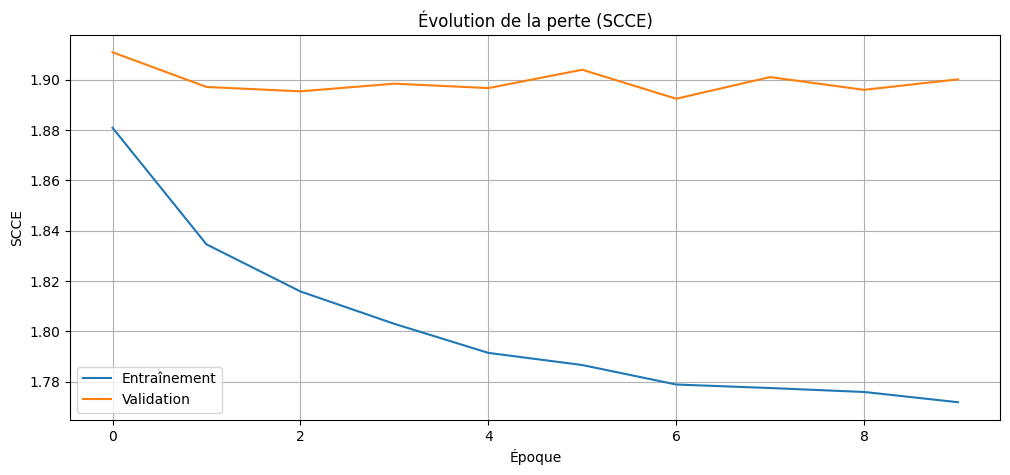

In [ ]:
# Courbes d'entraînement et de validation
plt.figure(figsize=(12, 5))
plt.plot(history_TFT.history['loss'], label='Entraînement')
plt.plot(history_TFT.history['val_loss'], label='Test')
plt.title('Évolution de la perte (SCCE)')
plt.xlabel('Époque')
plt.ylabel('SCCE')
plt.legend()
plt.grid(True)
plt.show()


#### Comparaison des Répartitions Réelles et Prédites

#### Objectif :
- Comparer les fréquences réelles des classes (\( y_{\text{test}} \)) avec les fréquences prédites :
  1. En utilisant la classe prédite la plus probable (argmax).
  2. En utilisant les probabilités moyennes prédites pour chaque classe.

#### Résultat :
- Deux graphiques :
  1. **Répartition réelle vs prédite (argmax)** : Compare les classes les plus probables.
  2. **Répartition réelle vs probabilité moyenne** : Compare les fréquences réelles avec les moyennes des prédictions.

45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step


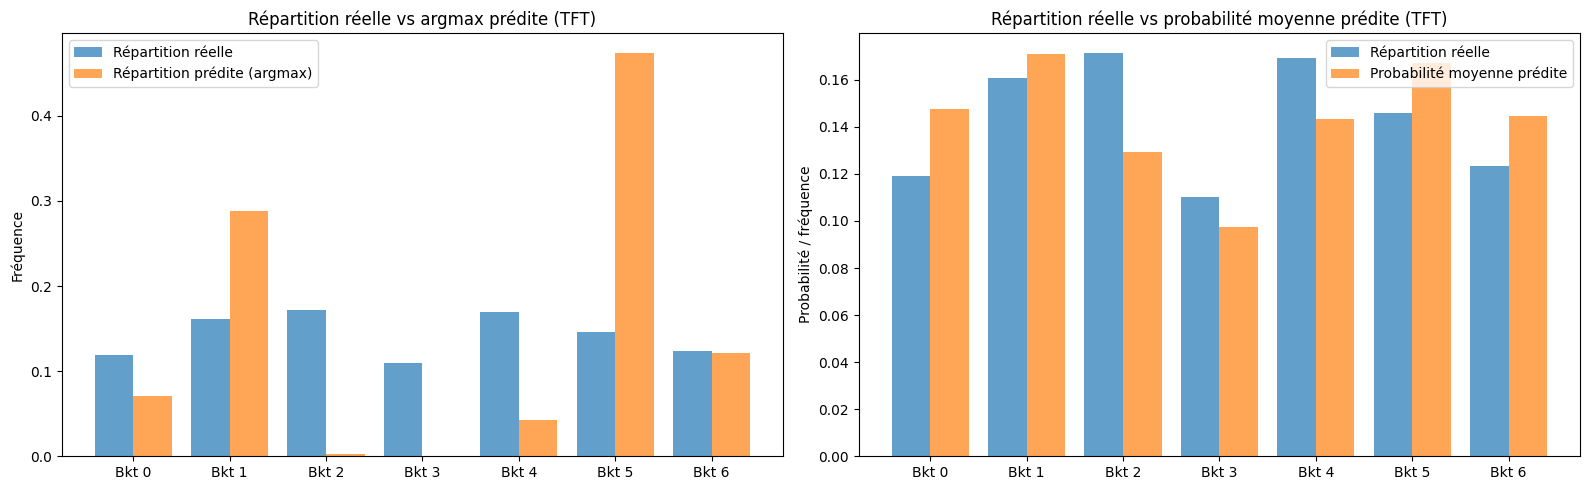

In [ ]:
y_proba_TFT = model_TFT.predict(X_test_seq)
y_argmax_TFT = np.argmax(y_proba_TFT, axis=1)

true_counts = np.bincount(y_test_seq, minlength=n_buckets)
pred_counts = np.bincount(y_argmax_TFT, minlength=n_buckets)

true_freq = true_counts / true_counts.sum()
pred_freq = pred_counts / pred_counts.sum()

indices = np.arange(n_buckets)
bar_width = 0.4

mean_proba = y_proba_TFT.mean(axis=0)  # Moyenne des probabilités

# Création d'une figure avec deux graphiques côte à côte
plt.figure(figsize=(16, 5))

# Graphique 1 : Répartition réelle vs Répartition prédite (argmax)
plt.subplot(1, 2, 1)
plt.bar(indices - bar_width / 2, true_freq, width=bar_width, alpha=0.7, label="Répartition réelle")
plt.bar(indices + bar_width / 2, pred_freq, width=bar_width, alpha=0.7, label="Répartition prédite (argmax)")
plt.xticks(indices, [f"Bkt {i}" for i in indices])
plt.ylabel("Fréquence")
plt.title("Répartition réelle vs argmax prédite (TFT)")
plt.legend()

# Graphique 2 : Répartition réelle vs Probabilité moyenne prédite
plt.subplot(1, 2, 2)
plt.bar(indices - bar_width / 2, true_freq, width=bar_width, alpha=0.7, label="Répartition réelle")
plt.bar(indices + bar_width / 2, mean_proba, width=bar_width, alpha=0.7, label="Probabilité moyenne prédite")
plt.xticks(indices, [f"Bkt {i}" for i in indices])
plt.ylabel("Probabilité / fréquence")
plt.title("Répartition réelle vs probabilité moyenne prédite (TFT)")
plt.legend()

# Ajustement de la mise en page
plt.tight_layout()
plt.show()


### Étape 8 : Ajout d'Indices Financiers et Comparaison

#### Objectif :
- Enrichir les données avec des indicateurs financiers couramment utilisés pour améliorer les performances du modèle TFT.

#### Nouveaux Indicateurs Ajoutés :
1. **RSI (Relative Strength Index)** :
   - Indicateur technique mesurant la vitesse et l'amplitude des variations de prix.

2. **MACD (Moving Average Convergence Divergence)** :
   - Indicateur basé sur les moyennes mobiles pour évaluer la tendance des prix.

3. **Bandes de Bollinger** :
   - Indicateur mesurant la volatilité en traçant des bandes autour d'une moyenne mobile.

4. **Momentum et ROC (Rate Of Change)** :
   - Indicateurs mesurant la vitesse de variation des prix.

#### Prochaine Étape :
- Intégrer ces indicateurs aux features existants.
- Comparer les performances des modèles avec et sans ces indicateurs pour évaluer leur impact.


In [ ]:
df_full = df_seq.copy()

# Ajout des indicateurs techniques
df_full["RSI_14"] = ta.rsi(df_full["Price"], length=14)

# Ajout du MACD
macd = ta.macd(df_full["Price"])
df_full["MACD"] = macd["MACD_12_26_9"]
df_full["MACD_Signal"] = macd["MACDs_12_26_9"]
df_full["MACD_Hist"] = macd["MACDh_12_26_9"]

# Ajout des Bandes de Bollinger
bbands = ta.bbands(df_full["Price"], length=20, std=2)
df_full["BB_Lower"] = bbands["BBL_20_2.0"]
df_full["BB_Mid"] = bbands["BBM_20_2.0"]
df_full["BB_Upper"] = bbands["BBU_20_2.0"]

# Ajout du Momentum et du ROC (Rate of Change)
df_full["Momentum_5"] = ta.mom(df_full["Price"], length=5) 
df_full["ROC_5"] = ta.roc(df_full["Price"], length=5)     


# Suppression des lignes NaN
df_full.dropna(inplace=True)

# Vérification et correction des types des colonnes (si nécessaire)
for col in ["RSI_14", "MACD", "MACD_Signal", "MACD_Hist", "BB_Lower", "BB_Mid", "BB_Upper", "Momentum_5", "ROC_5"]:
    df_full[col] = pd.to_numeric(df_full[col], errors='coerce')

# Suppression des lignes NaN après correction
df_full.dropna(inplace=True)


cuts_full = df_full['FutureReturn'].quantile(quantiles).values

print("Cut edges (quantiles):", cuts_full)

df_full['FutureReturn_bucket'] = pd.cut(
    df_full['FutureReturn'],
    bins=cuts_full,            
    labels=False,         
    include_lowest=True   
)


exclude_cols_full = ["Price", "Return", "FutureReturn", "FutureReturn_bucket"]
feature_cols_full = [c for c in df_full.columns if c not in exclude_cols_full]
X_full = df_full[feature_cols_full].values
y_full = df_full["FutureReturn_bucket"].values.astype(int)  

N_full = len(df_full)
Nt_full = int(0.8 * N_full)
Nv_full = N_full - Nt_full

X_train_full, X_test_full = X_full[:Nt_full], X_full[Nt_full:]
y_train_full, y_test_full = y_full[:Nt_full], y_full[Nt_full:]
scaler_full = StandardScaler()
X_train_scaled_full = scaler_full.fit_transform(X_train_full)
X_test_scaled_full  = scaler_full.transform(X_test_full)

seq_length = 35

X_train_seq_full, y_train_seq_full = create_sequences(X_train_scaled_full, y_train_full, seq_length)
X_test_seq_full,  y_test_seq_full  = create_sequences(X_test_scaled_full,  y_test_full,  seq_length)

print(f"Forme X_train_seq_full : {X_train_seq_full.shape}")
print(f"Forme y_train_seq_full : {y_train_seq_full.shape}")

y_train_cat_full = to_categorical(y_train_seq_full, num_classes=n_buckets)
y_test_cat_full  = to_categorical(y_test_seq_full,  num_classes=n_buckets)

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False) 

Cut edges (quantiles): [-0.19116565 -0.01851826 -0.00823029 -0.00171468  0.0020003   0.00864756
  0.0193249   0.18874477]
Forme X_train_seq_full : (5748, 35, 102)
Forme y_train_seq_full : (5748,)


# Modèle TFT avec les features supplémentaires

In [26]:
num_features_full = X_train_seq_full.shape[2]


tft_full = TemporalFusionTransformer(
    seq_length=seq_length,
    num_features=num_features_full,
    n_buckets=n_buckets   
)
model_TFT_full = tft_full.build_model()

history_TFT_full = model_TFT_full.fit(
    X_train_seq_full, y_train_seq_full,
    validation_data=(X_test_seq_full, y_test_seq_full),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Évaluation
loss_TFT_full, acc_TFT_full = model_TFT_full.evaluate(X_test_seq_full, y_test_seq_full, verbose=0)
print(f"\nTFT - Test Cross-Entropy : {loss_TFT_full:.4f}")
print(f"TFT - Test Accuracy      : {acc_TFT_full:.2%}")


Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - accuracy: 0.2100 - loss: 1.9329 - val_accuracy: 0.1538 - val_loss: 1.9311
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.2291 - loss: 1.8591 - val_accuracy: 0.1800 - val_loss: 1.9099
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.2224 - loss: 1.8380 - val_accuracy: 0.1765 - val_loss: 1.9020
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 19s 103ms/step - accuracy: 0.2298 - loss: 1.8219 - val_accuracy: 0.1722 - val_loss: 1.9014
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - accuracy: 0.2352 - loss: 1.8088 - val_accuracy: 0.1800 - val_loss: 1.9066
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.2369 - loss: 1.8063 - val_accuracy: 0.1694 - val_loss: 1.9088
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.2506 - loss: 1.8002 - val_accuracy: 0.1715 - val_loss: 1.9088
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.2476 - loss: 1.7952 

# Modèle LSTM avec les features supplémentaire

In [27]:
model_lstm_full = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_length, X_train_seq_full.shape[2])),
    tf.keras.layers.LSTM(64, return_sequences=True, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(64, return_sequences=False, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(n_buckets, activation='softmax')  
])

model_lstm_full.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


history_lstm_full = model_lstm_full.fit(
    X_train_seq_full, y_train_seq_full,
    validation_data=(X_test_seq_full, y_test_seq_full),
    epochs=10,
    batch_size=32,
    verbose=1
)

loss_lstm_full, acc_lstm_full = model_lstm_full.evaluate(X_test_seq_full, y_test_seq_full, verbose=0)
print(f"\nTest loss (cross-entropy) : {loss_lstm_full:.4f}")
print(f"Test accuracy             : {acc_TFT_full:.2%}")
#y_proba = model_lstm.predict(X_test_seq)
#predicted_buckets = np.argmax(y_proba, axis=1)

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.1905 - loss: 1.9355 - val_accuracy: 0.1871 - val_loss: 1.9269
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.2341 - loss: 1.8724 - val_accuracy: 0.1793 - val_loss: 1.9403
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.2424 - loss: 1.8505 - val_accuracy: 0.1786 - val_loss: 1.9096
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.2529 - loss: 1.8357 - val_accuracy: 0.1878 - val_loss: 1.9649
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.2516 - loss: 1.8351 - val_accuracy: 0.2006 - val_loss: 1.9103
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.2513 - loss: 1.8287 - val_accuracy: 0.1921 - val_loss: 1.9265
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.2518 - loss: 1.8255 - val_accuracy: 0.1984 - val_loss: 1.8982
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.2570 - loss: 1.8184 - val_acc